In [2]:
import pandas as pd
import numpy as np


import mysql.connector as sql

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR
import xgboost as xgb

from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
df = pd.read_csv("data.csv")

In [4]:
df = df[['year','make','model','listing_mileage','listing_price']]

In [5]:
df.head(2)

,year,make,model,listing_mileage,listing_price
0,2015,Kia,FORTE,53960.0,NaN
1,2017,GMC,Sierra 1500,99697.0,32999.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4610388 entries, 0 to 4610387
Data columns (total 5 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   year             int64 
 1   make             object
 2   model            object
 3   listing_mileage  object
 4   listing_price    object
dtypes: int64(1), object(4)
memory usage: 175.9+ MB


## Handeling null and trash values
#### 1. removing trash values from listing_mileage and listing_price.
#### 2. removing rows having null make and null model(very less in                number <0.5%)
#### 3. removing trash values in make and model
#### 4. adding make and model column to make simgle column mm

In [7]:
df['listing_price']=df['listing_price'].replace('[^0-9]',np.nan,regex=True)
df['listing_mileage']=df['listing_mileage'].replace('[^0-9]',np.nan,regex=True)

In [8]:
df['listing_price']=df['listing_price'].astype(float)
df['listing_mileage']=df['listing_mileage'].astype(float)

In [9]:
df['make'].isna().value_counts() # 0.8% of data is null

make
False    4572507
True       37881
Name: count, dtype: int64

In [10]:
count1 = df[(df['make'].isna()) & (df['model'].isna())].shape[0]
count1

15599

In [11]:
# Removing rows having both make and model = null

In [12]:
df = df.dropna(subset=['make', 'model'], how='all')

In [13]:
# Reset the index of the DataFrame
df = df.reset_index(drop=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4594789 entries, 0 to 4594788
Data columns (total 5 columns):
 #   Column           Dtype  
---  ------           -----  
 0   year             int64  
 1   make             object 
 2   model            object 
 3   listing_mileage  float64
 4   listing_price    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 175.3+ MB


In [15]:
df['make'].isna().value_counts()

make
False    4572507
True       22282
Name: count, dtype: int64

In [16]:
df['model'].isna().value_counts()

model
False    4590860
True        3929
Name: count, dtype: int64

In [17]:
df = df.sort_values(by='model')
# forward filling null values of make
df['make'] = df['make'].fillna(method='ffill')

In [18]:
df = df.sort_values(by='make')
# forward filling null values of make
df['model'] = df['model'].fillna(method='ffill')

In [19]:
df['make'].isna().value_counts()

make
False    4594789
Name: count, dtype: int64

In [20]:
df['model'].isna().value_counts()

model
False    4594789
Name: count, dtype: int64

In [21]:
# removing trash values from make and model column 

In [22]:
df['make'] = df['make'].str.replace('[^\w\s]', '', regex=True)
df['model'] = df['model'].str.replace('[^\w\s]', '', regex=True)

In [23]:
#combining make amd model columns 
df['mm']=df['make']+' '+df['model']

In [24]:
df['mm'].isna().value_counts()

mm
False    4594789
Name: count, dtype: int64

In [25]:
df['mm'] = df['mm'].str.lstrip()


In [26]:
df['mm'].nunique()

251962

In [27]:
df.head(2)

,year,make,model,listing_mileage,listing_price,mm
2308314,2012,Forest River TOYHAULER,VISION,NaN,NaN,Forest River TOYHAULER VISION
2924498,2004,Forest River TOYHAULER,VISION 31093400,NaN,87035.0,Forest River TOYHAULER VISION 31093400


## Making clusters

### if mm count >= 100 make seperate cluster for each mm.
### if mm count < 100 aggregate in a seperate cluster

In [142]:
counts = df['mm'].value_counts()
threshold = 99

keep_mm = counts[counts > threshold].index
keep_mm

Index(['Ford F150', 'Chevrolet Silverado 1500', 'Ram 1500',
       'Chevrolet Equinox', 'Ford Explorer', 'Ford Escape', 'Nissan Rogue',
       'Toyota Camry', 'Jeep Grand Cherokee', 'Toyota Tacoma',
       ...
       'Dodge Durango SXT AWD',
       'Dodge Durango RT RWD 2WD Sport Utility Vehicles',
       'Porsche Macan GTS SUV', 'Nissan Rogue SUV', 'Toyota Sienna XLE Van',
       'Dodge Durango RT Plus', 'MercedesBenz E 300', 'BMW X5 xDrive50i SAV',
       'Ram 3500 Big Horn Truck Crew Cab', 'Jeep Wrangler 2dr '],
      dtype='object', name='mm', length=2930)

In [143]:
# function to keep the more frequent values and aggregate less frequent values
def aggr_rare_values(column1, column2, value):
    # Create a boolean mask to select the non-matching values
    mask = ~column1.isin(column2)
    
    # Create a new Series with the non-matching values replaced
    result = column1.where(~mask, value)
    
    return result

In [144]:
df['mm'] = aggr_rare_values(df['mm'],keep_mm,"rare")

In [145]:
df['mm'].value_counts()

mm
rare                                729316
Ford F150                           127656
Chevrolet Silverado 1500             92175
Ram 1500                             87313
Chevrolet Equinox                    52491
                                     ...  
Jeep Wrangler 2dr                      100
Chevrolet 1XP26                        100
Ram 3500 Big Horn Truck Crew Cab       100
Jeep Wrangler JK Sport 4x4 SUV         100
Nissan Rogue SUV                       100
Name: count, Length: 2931, dtype: int64

In [146]:
le = LabelEncoder()
df['cluster'] = le.fit_transform(df['mm'])

In [147]:
df['mm'].head(4100000)

2308314              rare
2924498              rare
1515809              rare
3384701              rare
4587536              rare
                ...      
4221477    Toyota 4Runner
1114700    Toyota 4Runner
2464661    Toyota 4Runner
3694837    Toyota 4Runner
2257553    Toyota 4Runner
Name: mm, Length: 4100000, dtype: object

In [148]:
df['listing_mileage'].isna().value_counts()

listing_mileage
False    3729780
True      865009
Name: count, dtype: int64

In [149]:
df['listing_price'].isna().value_counts()

listing_price
False    4079694
True      515095
Name: count, dtype: int64

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4594789 entries, 2308314 to 3825204
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   year             int64  
 1   make             object 
 2   model            object 
 3   listing_mileage  float64
 4   listing_price    float64
 5   mm               object 
 6   cluster          int32  
dtypes: float64(2), int32(1), int64(1), object(3)
memory usage: 262.9+ MB


### Removing rows having both listing mileage and price null

In [151]:
df = df.query('listing_mileage.notnull() or listing_price.notnull()')

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4427578 entries, 2924498 to 3825204
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   year             int64  
 1   make             object 
 2   model            object 
 3   listing_mileage  float64
 4   listing_price    float64
 5   mm               object 
 6   cluster          int32  
dtypes: float64(2), int32(1), int64(1), object(3)
memory usage: 253.3+ MB


In [153]:
print(df[(df['listing_price'].isna())&(df['listing_mileage'].isna())])

Empty DataFrame
Columns: [year, make, model, listing_mileage, listing_price, mm, cluster]
Index: []


# Functions: 

### function to get outliers :

In [154]:

def find_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR = q3 - q1
    outliers = df[((df[column] < (q1 - 1.5 * IQR)) | (df[column] > (q3 + 1.5 * IQR)))]
    
    # Count the number of outliers
    num_outliers = len(outliers)
    

    
    return outliers, num_outliers


###  function to remove rows having outliers :

In [155]:

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

### function to handle null values in listing price and mileage column using linear regression :

In [156]:

def fillna_val(gh,col):
    
    hg = gh.copy()
    
    #removing outliers for training data
    hg = remove_outliers(hg,'listing_mileage')
    hg = remove_outliers(hg,'listing_price')
    hg = hg.dropna()
    
    x_lm = hg.drop(['make','model','mm','cluster',col], axis=1)
    y_lp = hg[col]
    x_lm = x_lm.dropna()
    y_lp = y_lp.dropna()
    
    
    model = LinearRegression()
    model.fit(x_lm,y_lp)

    mask = gh[col].isna()
    if mask.any():
        result = gh.loc[mask].drop(['make','model','mm','cluster',col], axis=1)

        y_pred = model.predict(result)
        gh.loc[mask, [col]] = y_pred

    gh['listing_mileage'] = gh['listing_mileage'].clip(lower=0) # make -ve values 0
    gh['listing_price'] = gh['listing_price'].clip(lower=0)



    return gh 
    
    
   

In [157]:
find_outliers(df,'listing_price')

(         year        make                                              model  \
 440252   2021        1492  1492 Coachworks Toy Hauler for sale near Mount...   
 4534979  2023        ADES                                        ATV 168 1EB   
 1633290  2021   AIRSTREAM                                         All Models   
 3468153  1993  AM General                                             Humvee   
 916666   2000  AM General                                  General Hummer H1   
 ...       ...         ...                                                ...   
 2328512  2022      Yamaha                                             Vision   
 1704827  2022      ZINGER                                               31VA   
 167787   2022      ZINGER                                               31VA   
 3849430  2012  rollsroyce                    ROYCE GHOST EXTENDED WHEEL BASE   
 675031   2002  western rv                                   ADVENTURER 810WS   
 
          listing_mileage 

In [158]:
find_outliers(df,'listing_mileage')

(         year           make           model  listing_mileage  listing_price  \
 4556094  1987           1987  12 Ton Pickups         208000.0        14500.0   
 3303908  2021    ASPEN TRAIL            26BH         999999.0        37995.0   
 556179   2012          Acura             MDX         238000.0        14800.0   
 3169553  2005          Acura             MDX         282706.0         1500.0   
 3042773  2007          Acura             MDX         225000.0         5995.0   
 ...       ...            ...             ...              ...            ...   
 4029837  2012  international            4400         327209.0            NaN   
 3171215  2011  international            4300         205139.0            NaN   
 4446131  2014  international            4300         225102.0            NaN   
 3999406  2012  international         prostar         448789.0        18000.0   
 1622624  2010             ud      2000K Gray         359718.0        17997.0   
 
                 mm  clust

## Analysing data for Toyota Camry 

In [159]:
gh = df[df['mm']=='Toyota Camry']
gh.head(2)

,year,make,model,listing_mileage,listing_price,mm,cluster
4257809,2015,Toyota,Camry,NaN,14825.0,Toyota Camry,2669
1323277,2017,Toyota,Camry,110888.0,17995.0,Toyota Camry,2669


In [160]:
gh = df[df['cluster']==2669]

gh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38330 entries, 4257809 to 2841259
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             38330 non-null  int64  
 1   make             38330 non-null  object 
 2   model            38330 non-null  object 
 3   listing_mileage  31174 non-null  float64
 4   listing_price    34852 non-null  float64
 5   mm               38330 non-null  object 
 6   cluster          38330 non-null  int32  
dtypes: float64(2), int32(1), int64(1), object(3)
memory usage: 2.2+ MB


In [161]:
gh['listing_mileage'].isna().value_counts()

listing_mileage
False    31174
True      7156
Name: count, dtype: int64

In [162]:
gh['listing_price'].isna().value_counts()

listing_price
False    34852
True      3478
Name: count, dtype: int64

In [163]:
find_outliers(gh,'listing_mileage')

(         year    make  model  listing_mileage  listing_price            mm  \
 1676766  2004  Toyota  Camry         336221.0         3990.0  Toyota Camry   
 17034    2007  Toyota  Camry         251000.0         6800.0  Toyota Camry   
 1556379  2008  Toyota  Camry         234554.0         2988.0  Toyota Camry   
 3324559  2013  Toyota  Camry         251000.0         7495.0  Toyota Camry   
 3758153  2012  Toyota  Camry         261415.0         6500.0  Toyota Camry   
 ...       ...     ...    ...              ...            ...           ...   
 1300342  2001  Toyota  Camry         368907.0         3900.0  Toyota Camry   
 3468295  2010  Toyota  Camry         272439.0         7500.0  Toyota Camry   
 1384945  2002  Toyota  Camry         226288.0         2788.0  Toyota Camry   
 1525127  2012  Toyota  Camry         246849.0         8997.0  Toyota Camry   
 4001214  2015  Toyota  Camry         236564.0        13950.0  Toyota Camry   
 
          cluster  
 1676766     2669  
 17034    

In [164]:
find_outliers(gh,'listing_price')

(         year    make  model  listing_mileage  listing_price            mm  \
 960236   2018  Toyota  Camry          27990.0        98003.0  Toyota Camry   
 4064180  2018  Toyota  Camry          26590.0        57445.0  Toyota Camry   
 898456   2022  Toyota  Camry          29076.0        91740.0  Toyota Camry   
 1019082  2019  Toyota  Camry          33988.0        94591.0  Toyota Camry   
 3673933  2012  Toyota  Camry          16995.0        83401.0  Toyota Camry   
 ...       ...     ...    ...              ...            ...           ...   
 2088378  2008  Toyota  Camry         180000.0       111111.0  Toyota Camry   
 1515478  2016  Toyota  Camry          18652.0        62263.0  Toyota Camry   
 1207785  2020  Toyota  Camry          27995.0        81505.0  Toyota Camry   
 2841103  2017  Toyota  Camry          29995.0        83544.0  Toyota Camry   
 3762479  2011  Toyota  Camry          11950.0        60020.0  Toyota Camry   
 
          cluster  
 960236      2669  
 4064180  

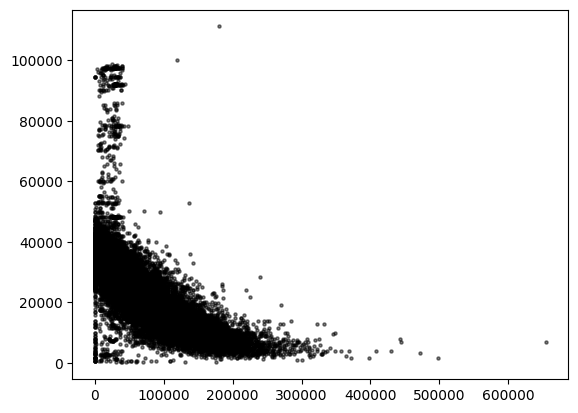

In [165]:
plt.scatter(gh['listing_mileage'], gh['listing_price'], alpha=0.5, marker='o', c='k',s=5)


#### NOTE: by removing outliers it also remove the null values in the data not preferable

In [166]:
gh = fillna_val(gh,'listing_price')
gh = fillna_val(gh,'listing_mileage')

In [167]:
gh['listing_price'].isna().value_counts()

listing_price
False    38330
Name: count, dtype: int64

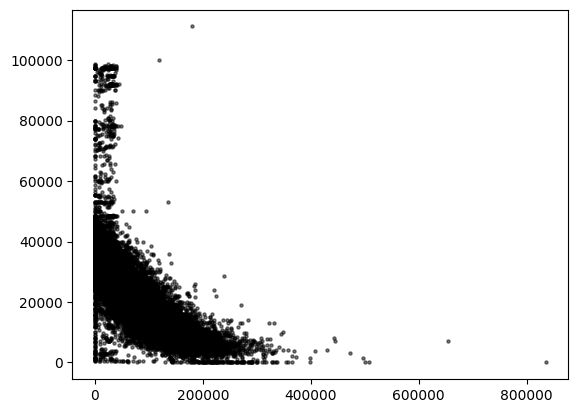

In [168]:

plt.scatter(gh['listing_mileage'], gh['listing_price'], alpha=0.5, marker='o', c='k',s=5)


In [169]:
gh = remove_outliers(gh,'listing_mileage')
gh = remove_outliers(gh,'listing_price')
gh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36886 entries, 4257809 to 2841259
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             36886 non-null  int64  
 1   make             36886 non-null  object 
 2   model            36886 non-null  object 
 3   listing_mileage  36886 non-null  float64
 4   listing_price    36886 non-null  float64
 5   mm               36886 non-null  object 
 6   cluster          36886 non-null  int32  
dtypes: float64(2), int32(1), int64(1), object(3)
memory usage: 2.1+ MB


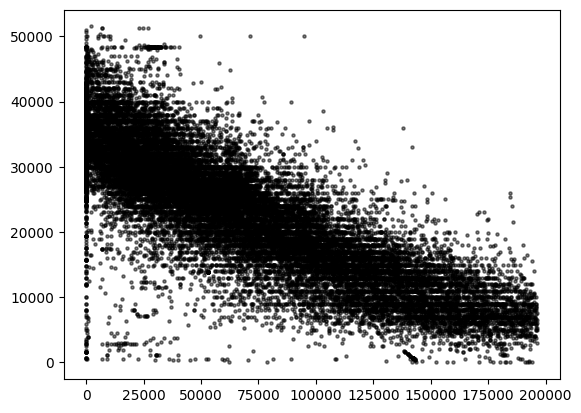

In [170]:
plt.scatter(gh['listing_mileage'], gh['listing_price'], alpha=0.5, marker='o', c='k',s=5)


#### implementing ridge regression

In [171]:
X_train,X_test,y_train,y_test = train_test_split(gh.drop(columns=['listing_price','mm','cluster','make','model']),gh['listing_price'],test_size=0.2, shuffle = True)

In [172]:
ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

In [173]:
r2 = r2_score(y_test, y_pred)
r2

0.8059323019646403

In [174]:
# gh["listing_price"] = gh["listing_price"].interpolate(method='values')
# gh["listing_mileage"] = gh["listing_mileage"].interpolate(method='values')

In [175]:
# Calculate the MSE and RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Calculate the standard deviation of the data
std_dev = np.std(y_test)

print(f'Mean absolute error: {mae:.2f}')
print(f'Root mean squared error: {rmse:.2f}')
print(f'Standard deviation: {std_dev:.2f}')

Mean absolute error: 2681.45
Root mean squared error: 4057.77
Standard deviation: 9211.08


In [176]:
scores = cross_val_score(ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

scores

array([-16382125.60600998, -16650972.5728396 , -16811714.57499564,
       -16209360.22951826, -15310516.19254241])

In [177]:
# Calculate the average MSE across the 5 folds
mse = -scores.mean()
rmse = np.sqrt(mse)
print(f'Root mean squared error: {rmse:.2f}')
print(f'Average mean squared error: {mse:.2f}')

Root mean squared error: 4033.97
Average mean squared error: 16272937.84


In [178]:
scores = cross_val_score(ridge, X_train, y_train, cv=5, scoring='r2')

scores

array([0.80183135, 0.8077441 , 0.80406302, 0.8059684 , 0.81381269])

In [179]:
scores.mean()

0.8066839109680946

## For each cluster
#### filling null values in listing price and listing mileage
#### removing outliers

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4427578 entries, 2924498 to 3825204
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   year             int64  
 1   make             object 
 2   model            object 
 3   listing_mileage  float64
 4   listing_price    float64
 5   mm               object 
 6   cluster          int32  
dtypes: float64(2), int32(1), int64(1), object(3)
memory usage: 253.3+ MB


In [181]:
df['cluster'].nunique()

2931

In [182]:
print(df.count())

year               4427578
make               4427578
model              4427578
listing_mileage    3729780
listing_price      4079694
mm                 4427578
cluster            4427578
dtype: int64


### Checking for which clusters fillna() functions are breaking

In [183]:
for i in range(2564,2931):
    gh = df[df['cluster']==i]
    gh = fillna_val(gh,'listing_price')
    gh = fillna_val(gh,'listing_mileage')
    print(i)
    i = i+1
    

2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644
2645
2646
2647
2648
2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662
2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673
2674
2675
2676
2677
2678
2679
2680
2681
2682
2683
2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695
2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707
2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718
2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763


In [184]:
gh1 = df[df['cluster']==1967]
gh1.head()

,year,make,model,listing_mileage,listing_price,mm,cluster
4485943,2022,Load Trail,DT8314,NaN,12600.0,Load Trail DT8314,1967
885120,2022,Load Trail,DT8314,NaN,4725.0,Load Trail DT8314,1967
921756,2022,Load Trail,DT8314,NaN,7172.0,Load Trail DT8314,1967
1301697,2022,Load Trail,DT8314,NaN,2932.0,Load Trail DT8314,1967
1311644,2022,Load Trail,DT8314,NaN,2999.0,Load Trail DT8314,1967


In [185]:
gh2 = df[df['cluster']==2547]
gh2.head()

,year,make,model,listing_mileage,listing_price,mm,cluster
2177642,2021,SSR,70 Fox,300.0,NaN,SSR 70 Fox,2547
4223181,2021,SSR,70 Fox,6.0,NaN,SSR 70 Fox,2547
1973533,2021,SSR,70 Fox,6.0,NaN,SSR 70 Fox,2547
267681,2021,SSR,70 Fox,6.0,NaN,SSR 70 Fox,2547
3602323,2021,SSR,70 Fox,6.0,NaN,SSR 70 Fox,2547


In [186]:
gh3 = df[df['cluster']==2563]
gh3.head()

,year,make,model,listing_mileage,listing_price,mm,cluster
2011186,2022,Sonic,SNARLER,1.0,NaN,Sonic SNARLER,2563
8562,2022,Sonic,SNARLER,1.0,NaN,Sonic SNARLER,2563
3225538,2022,Sonic,SNARLER,1.0,NaN,Sonic SNARLER,2563
1384568,2022,Sonic,SNARLER,1.0,NaN,Sonic SNARLER,2563
3837863,2022,Sonic,SNARLER,1.0,NaN,Sonic SNARLER,2563


#### removing above clusters

In [187]:
cluster_col = 'cluster'
clusters_to_delete = [1967, 2547, 2563]

# Create a mask to identify the rows to delete
mask = df[cluster_col].isin(clusters_to_delete)

# Delete the rows from the DataFrame
df = df[~mask]

In [188]:
i =0
for cluster in df['cluster'].unique():
    
    cluster_data = df[df['cluster'] == cluster]
    
    cluster_data = fillna_val(cluster_data,'listing_price')
    cluster_data = fillna_val(cluster_data,'listing_mileage')
    
    
    cluster_data = remove_outliers(cluster_data,'listing_mileage')
    cluster_data = remove_outliers(cluster_data,'listing_price')
    
    
    
    # update the original dataframe with the cleaned data
    df.loc[df['cluster'] == cluster] = cluster_data
    print(i)
    i=i+1


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4427215 entries, 2924498 to 3825204
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   year             float64
 1   make             object 
 2   model            object 
 3   listing_mileage  float64
 4   listing_price    float64
 5   mm               object 
 6   cluster          float64
dtypes: float64(4), object(3)
memory usage: 270.2+ MB


### Checking how the data is distributed after filling na values and removing outliers

In [190]:
gh = df[df['cluster']==2660]

In [191]:
gh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124 entries, 3244846 to 2950737
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   year             124 non-null    float64
 1   make             124 non-null    object 
 2   model            124 non-null    object 
 3   listing_mileage  124 non-null    float64
 4   listing_price    124 non-null    float64
 5   mm               124 non-null    object 
 6   cluster          124 non-null    float64
dtypes: float64(4), object(3)
memory usage: 7.8+ KB


In [192]:
gh['listing_mileage'].isna().value_counts()

listing_mileage
False    124
Name: count, dtype: int64

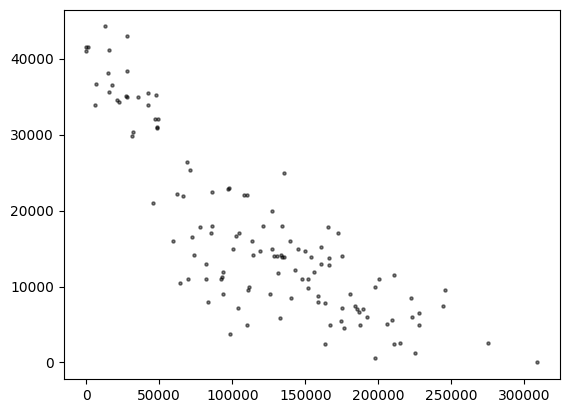

In [193]:
plt.scatter(gh['listing_mileage'], gh['listing_price'], alpha=0.5, marker='o', c='k',s=5)


### again rearranging cluster column

In [196]:
df = df.drop('cluster', axis = 1)

In [197]:
df.head(2)

,year,make,model,listing_mileage,listing_price,mm
2924498,2004.0,Forest River TOYHAULER,VISION 31093400,66308.568048,87035.0,rare
1515809,2008.0,Forest River TOYHAULER,VISION 31093400,53436.292461,87035.0,rare


In [198]:
# Reset the index of the DataFrame
df = df.reset_index(drop=True)

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4427215 entries, 0 to 4427214
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   year             float64
 1   make             object 
 2   model            object 
 3   listing_mileage  float64
 4   listing_price    float64
 5   mm               object 
dtypes: float64(3), object(3)
memory usage: 202.7+ MB


#### again encoding to make cluster column

In [200]:
df['mm'] = df['make']+' '+df['model']
counts = df['mm'].value_counts()
threshold = 99

keep_mm2 = counts[counts > threshold].index
keep_mm2

Index(['Ford F150', 'Chevrolet Silverado 1500', 'Ram 1500',
       'Chevrolet Equinox', 'Ford Explorer', 'Ford Escape', 'Nissan Rogue',
       'Jeep Grand Cherokee', 'Toyota Camry', 'Nissan Altima',
       ...
       'Volkswagen Tiguan SE RLine Black',
       'Acura MDX SHAWD with ASpec Package SUV',
       'Chevrolet Equinox Premier w2LZ SUV',
       'Volvo XC60 B5 FWD Inscription SUV', 'Toyota RAV4 Hybrid SE SUV',
       'Jeep Renegade LIMITED 4X4', 'Jeep Wrangler Sahara SUV',
       'Jeep Cherokee Limited FWD SUV', 'Chevrolet Silverado 3500 HD LT Truck',
       'Infiniti G35 Sedan'],
      dtype='object', name='mm', length=2618)

In [201]:
df['mm'] = aggr_rare_values(df['mm'],keep_mm2,"rare")

In [202]:
df[df['mm']=='rare']

,year,make,model,listing_mileage,listing_price,mm
0,2004.0,Forest River TOYHAULER,VISION 31093400,66308.568048,87035.0,rare
1,2008.0,Forest River TOYHAULER,VISION 31093400,53436.292461,87035.0,rare
2,2006.0,Forest River TOYHAULER,VISION 31093400,59872.430255,87035.0,rare
3,1997.0,Forest River TOYHAULER,VISION,38503.000000,18900.0,rare
4,2015.0,Forest River TOYHAULER,VIPER XLR 305V12,51768.007751,49900.0,rare
...,...,...,...,...,...,...
4427210,2002.0,western rv,ADVENTURER 810WS,69746.427705,92373.0,rare
4427211,2017.0,western rv,AE213RBSL17,59881.214015,23997.0,rare
4427212,2022.0,wolverine,20 aluminum deckover,501.000000,13950.0,rare
4427213,2022.0,xx Old Hickory Buildings,12x28 Lofted Barn,51104.017029,10977.0,rare


In [206]:
le = LabelEncoder()
df['cluster'] = le.fit_transform(df['mm'])

In [207]:
df.head(100000)

,year,make,model,listing_mileage,listing_price,mm,cluster
0,2004.0,Forest River TOYHAULER,VISION 31093400,66308.568048,87035.0,rare,2618
1,2008.0,Forest River TOYHAULER,VISION 31093400,53436.292461,87035.0,rare,2618
2,2006.0,Forest River TOYHAULER,VISION 31093400,59872.430255,87035.0,rare,2618
3,1997.0,Forest River TOYHAULER,VISION,38503.000000,18900.0,rare,2618
4,2015.0,Forest River TOYHAULER,VIPER XLR 305V12,51768.007751,49900.0,rare,2618
...,...,...,...,...,...,...,...
99995,2013.0,Audi,A4,105204.000000,11999.0,Audi A4,32
99996,2014.0,Audi,A4,97000.000000,15000.0,Audi A4,32
99997,2004.0,Audi,A4,106690.000000,15888.0,Audi A4,32
99998,2017.0,Audi,A4,88470.000000,28995.0,Audi A4,32


In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4427215 entries, 0 to 4427214
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   year             float64
 1   make             object 
 2   model            object 
 3   listing_mileage  float64
 4   listing_price    float64
 5   mm               object 
 6   cluster          int32  
dtypes: float64(3), int32(1), object(3)
memory usage: 219.6+ MB


In [209]:
# making rare in mm to original make+model

df['mm'] = df['make']+' '+df['model']

df = df.drop(['make','model'],axis = 1)

In [210]:
print(df[df['mm'].isna()])

         year  listing_mileage  listing_price   mm  cluster
24        NaN              NaN            NaN  NaN     2618
27        NaN              NaN            NaN  NaN     2618
30        NaN              NaN            NaN  NaN     2618
33        NaN              NaN            NaN  NaN     2618
35        NaN              NaN            NaN  NaN     2618
...       ...              ...            ...  ...      ...
4427176   NaN              NaN            NaN  NaN     2618
4427178   NaN              NaN            NaN  NaN     2618
4427180   NaN              NaN            NaN  NaN     2618
4427197   NaN              NaN            NaN  NaN     2618
4427207   NaN              NaN            NaN  NaN     2618

[321248 rows x 5 columns]


In [211]:
df['cluster'].nunique()

2619

In [ ]:
df.head(100)

In [ ]:
# dropping cluster 2928 having all null values

In [214]:



df = df.dropna()

In [215]:
df['cluster'].nunique()

2619

In [216]:
df.isna().value_counts()

year   listing_mileage  listing_price  mm     cluster
False  False            False          False  False      4105967
Name: count, dtype: int64

In [217]:
gh = df[df['cluster']==2618]
gh.head(100)

,year,listing_mileage,listing_price,mm,cluster
0,2004.0,66308.568048,87035.000000,Forest River TOYHAULER VISION 31093400,2618
1,2008.0,53436.292461,87035.000000,Forest River TOYHAULER VISION 31093400,2618
2,2006.0,59872.430255,87035.000000,Forest River TOYHAULER VISION 31093400,2618
3,1997.0,38503.000000,18900.000000,Forest River TOYHAULER VISION,2618
4,2015.0,51768.007751,49900.000000,Forest River TOYHAULER VIPER XLR 305V12,2618
...,...,...,...,...,...
105,2000.0,88634.000000,13695.410944,AM General General Hummer,2618
106,1997.0,32995.000000,20970.617245,AM General General Hummer Wagon,2618
107,1995.0,35450.000000,399.000000,AM General Hummer,2618
108,1994.0,1.000000,64900.000000,AM General Hummer,2618


In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4105967 entries, 0 to 4427214
Data columns (total 5 columns):
 #   Column           Dtype  
---  ------           -----  
 0   year             float64
 1   listing_mileage  float64
 2   listing_price    float64
 3   mm               object 
 4   cluster          int32  
dtypes: float64(3), int32(1), object(1)
memory usage: 172.3+ MB


In [219]:
# Reset the index of the DataFrame
df = df.reset_index(drop=True)

In [220]:
df.head(100000)

,year,listing_mileage,listing_price,mm,cluster
0,2004.0,66308.568048,87035.000000,Forest River TOYHAULER VISION 31093400,2618
1,2008.0,53436.292461,87035.000000,Forest River TOYHAULER VISION 31093400,2618
2,2006.0,59872.430255,87035.000000,Forest River TOYHAULER VISION 31093400,2618
3,1997.0,38503.000000,18900.000000,Forest River TOYHAULER VISION,2618
4,2015.0,51768.007751,49900.000000,Forest River TOYHAULER VIPER XLR 305V12,2618
...,...,...,...,...,...
99995,2022.0,60960.000000,92705.000000,Audi A6 Premium Sedan for Sale in Santa Ana,2618
99996,2022.0,22633.293499,61665.000000,Audi A6 Premium Sedan Near New York City,2618
99997,2022.0,12.000000,61665.000000,Audi A6 Premium Sedan Near New York City,2618
99998,2021.0,53990.000000,50131.000000,Audi A6 Premium Sedan For Sale in Portland,2618


In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4105967 entries, 0 to 4105966
Data columns (total 5 columns):
 #   Column           Dtype  
---  ------           -----  
 0   year             float64
 1   listing_mileage  float64
 2   listing_price    float64
 3   mm               object 
 4   cluster          int32  
dtypes: float64(3), int32(1), object(1)
memory usage: 141.0+ MB


### downloading the data into csv file :

In [224]:
df.to_csv('data2.csv')

In [225]:
dt = pd.read_csv('data2.csv')

In [226]:
import mysql.connector as sql

from mysql.connector import Error

In [227]:
connection =  sql.connect(
 host="localhost",
 user ="karan",
 password= "Karan@1414",
 database = "database"
 )
print(connection)

In [228]:
cursor = connection.cursor(prepared=True)

In [229]:
dt.head(2)

,Unnamed: 0,year,listing_mileage,listing_price,mm,cluster
0,0,2004.0,66308.568048,87035.0,Forest River TOYHAULER VISION 31093400,2618
1,1,2008.0,53436.292461,87035.0,Forest River TOYHAULER VISION 31093400,2618


In [230]:
dt = dt.convert_dtypes()
dt.dtypes

Unnamed: 0                  Int64
year                        Int64
listing_mileage           Float64
listing_price             Float64
mm                 string[python]
cluster                     Int64
dtype: object

In [231]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4105967 entries, 0 to 4105966
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       Int64  
 1   year             Int64  
 2   listing_mileage  Float64
 3   listing_price    Float64
 4   mm               string 
 5   cluster          Int64  
dtypes: Float64(2), Int64(3), string(1)
memory usage: 207.5 MB


In [232]:
dt['Unnamed: 0'].nunique()

4105967

In [233]:
#create table data

cursor.execute("""
    CREATE TABLE data2 (
        s_no INT PRIMARY KEY,
        year INT,
        listing_mileage FLOAT,
        listing_price FLOAT,
        mm VARCHAR(256),
        cluster INT
    )
""")

In [234]:
    try:
         for i,row in dt[['Unnamed: 0', 'year', 'mm', 'listing_mileage', 'listing_price', 'cluster']].iterrows():
                #here %S means string values 
                sql = """INSERT INTO data2 (s_no ,year,mm,listing_mileage,listing_price,cluster) 
                VALUES (?,?,?,?,?,?)"""
                cursor.execute(sql, tuple(row))

                # the connection is not auto committed by default, so we must commit to save our changes
                connection.commit()
    except Error as e:
        print("Error while connecting to MySQL", e)